In [2]:
import math
import scipy # Has linear algebra
import scipy.ndimage
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import matplotlib.patches as pch
%matplotlib inline

Principal Component Analysis
---

In statistics, principle component analysis (PCA) entails computing the SVD of a dataset after centering the data for each attribute around the mean. That is, write

$$
X = A - \mu_A I
$$

where $\mu_A = \mathrm{mean}(A)$ is the mean of the values in $A$. 

We can then decompose the matrix $X$ to get

$$
X  = U \Sigma V^T
$$

We take the first two principle components of $X$ and form $\hat\Sigma$ and $\hat V$. The matrix $U\hat\Sigma$ is then $n \times 2$ and it represents the data in $X$ collapsed into two columns for each row, instead of $m$ columns for each row.

One of the properties of the PCA is that it chooses the direction in which the data is the most variable for the first principle component direction (the first column of $V$). The second principle component direction (the second column of $V$), is the direction of most variability that is orthogonal to the first direction.

PCA is used to visualize high dimensional data. For example, in [this paper](https://www.pnas.org/content/102/20/7057/tab-figures-data0), the authors looked at the voting habits of senators in congress, wondering if you could tell if the voting habits of any given senator were predictable. Since that data is a matter of public record, we can try this method out to see what happens.

First, let the $n$ senators be numbered $0$, $1$, $2$, ... $n$. Then, let the $m$ issues they have voted on in a given session of congress be numbered $1$, ..., $m$. Write

$$
A_{i,j} = \left \{ 
\begin{array}{ll}
1 & \mathrm{voted\;yes} \\
-1 & \mathrm{voted\;no} \\
0 & \mathrm{did\;not\;vote} \\
\end{array}
\right .
$$

Then $A \in \mathbb{R}^{n \times m}$. Said differently:

> The $i$th row of $A$ is the row-vector of votes of Senator $i$. 

Next, let $X = A - \mu_A I$ be the zero centered version of $A$. Computing $T = U \hat \Sigma$ with $k=2$ gives a new matrix $T \in \mathbb{R}^{n \times 2})$ The we have:  

> The $i$th row of $T$ sums up Senator i's voting habits in two numbers.

In [2]:
# You can get all sorts of data bout how congress  votes at https://voteview.com/data
# Here I have downloaded the data for the Senate in the 116th congress, which is
# the one currently in session.

my_data = np.genfromtxt('data/S116_votes.csv', delimiter=',', dtype=np.int8)

'Number of senators: 87. Number of issues: 128'

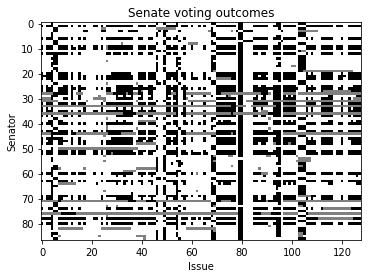

In [3]:
# The data is not in the form we want, so we have to transform it.
# The data's columns are
#    _, _, issue id, member id, vote outcome, _
# where _ means we don't need this colum.

issues = my_data[:,2] 

members = my_data[:,3]
member_ids = np.unique(members)
members = [np.where(member_ids == m)[0][0] for m in members]

votes = my_data[:,4]

yn = [ 0, 1, 1, 1, -1, -1, -1, 0, 0, 0 ]
votes = np.array([yn[v] for v in votes])

A = np.zeros((len(member_ids), max(issues)+1))
for member, issue, vote in zip(members, issues, votes):
    A[int(member),int(issue)] = vote

plt.imshow(A,cmap="gray");
plt.title("Senate voting outcomes")
plt.xlabel("Issue")
plt.ylabel("Senator")
    
"Number of senators: %d. Number of issues: %d" % A.shape

Text(0, 0.5, 'Value')

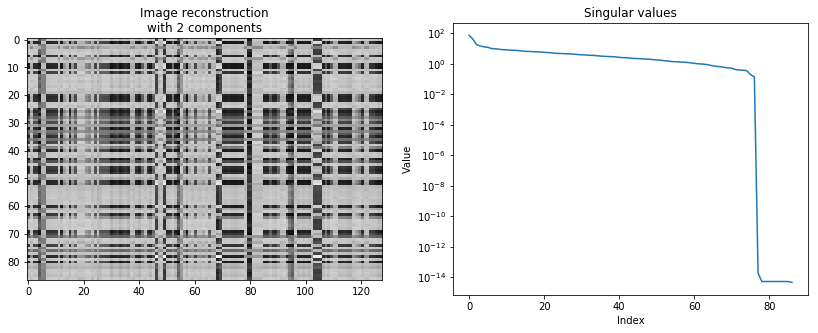

In [4]:
# Center the data at zero
X = A - np.mean(A)

# Singular-value decomposition
U, s, VT = scipy.linalg.svd(X)

# create m x n Sigma matrix
Sigma = np.zeros((A.shape[0], A.shape[1]))

# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[0], :A.shape[0]] = np.diag(s)

# select
n_elements = 2
Sigma = Sigma[:, :n_elements]
VT = VT[:n_elements, :]

# reconstruct
T = U.dot(Sigma)
B = T.dot(VT)

fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].imshow(B,cmap="gray");
ax[0].set_title("Image reconstruction\nwith %d components" % n_elements)
ax[1].semilogy(s);
ax[1].set_title("Singular values")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Value")

In [5]:
# Voting habits of Senator number 50
A[50]

array([ 1.,  1.,  1.,  1., -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [6]:
# Voting habits of Senator number 50 summed into two numbers
T[50]

array([-2.93626028, -4.41225838])

Text(0, 0.5, 'Second component')

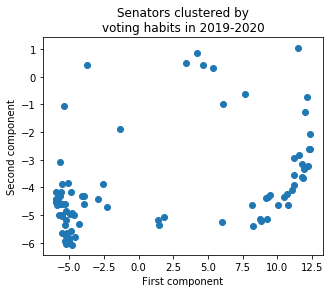

In [7]:
# Here's a plot of the data. It shows the senators clustering into two
# main clusters. One of the clusters is more varied than the other, suggesting
# more independence within that cluster. It also shows there are a number of 
# senators who do not really vote with either cluster.

T = U.dot(Sigma)
plt.scatter(T[:,0], T[:,1])
plt.gca().set_aspect(2)
plt.title("Senators clustered by\nvoting habits in 2019-2020")
plt.xlabel("First component")
plt.ylabel("Second component")

### Senators Revisited

Repeat the clustering of senators by voting habit for the years 1999, 1979 and 1959. Plot them together with the 2019 plot in a grid of plots. Which years seem the most divided? 

Note you will need to get the data at [https://voteview.com/data](https://voteview.com/data). Choose "Member's Votes", "Senate Only", the desired year, and CSV file. 

I had to edit the CSV file (in a text editor or ExCEL) to remove the heading in the first row before loading the file.

**Extra credit:** Color the each dot in the plots by whether the senator is a republican (red), democract (blue), or independent (green). This information is not in the data files above, so you'll need to find it elsewhere.

__Voting habits in the year 1999__

'Number of senators: 91. Number of issues: 128'

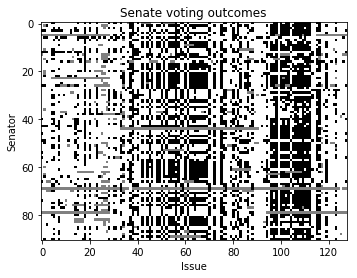

In [5]:
my_data99 = np.genfromtxt('data/S106_votes.csv', delimiter=',', dtype=np.int8)


issues = my_data99[:,2] 

members = my_data99[:,3]
member_ids = np.unique(members)
members = [np.where(member_ids == m)[0][0] for m in members]

votes = my_data99[:,4]

yn = [ 0, 1, 1, 1, -1, -1, -1, 0, 0, 0 ]
votes = np.array([yn[v] for v in votes])

A = np.zeros((len(member_ids), max(issues)+1))
for member, issue, vote in zip(members, issues, votes):
    A[int(member),int(issue)] = vote

plt.imshow(A,cmap="gray");
plt.title("Senate voting outcomes")
plt.xlabel("Issue")
plt.ylabel("Senator")
    
"Number of senators: %d. Number of issues: %d" % A.shape

In [39]:
data99 = pd.read_csv("data/S106_votes.csv")
data99.head()                     

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,106,Senate,1,1366,1,NaN
1,106,Senate,1,4812,1,NaN
2,106,Senate,1,9369,1,NaN
3,106,Senate,1,10808,1,NaN
4,106,Senate,1,11044,1,NaN


In [28]:
import pandas as pd
party_data99 = pd.read_csv("data/HSall_members.csv")
party_data99.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,1,President,99869,99,0,USA,5000,NaN,NaN,"WASHINGTON, George",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,House,4766,1,98,CT,5000,0.0,1.0,"HUNTINGTON, Benjamin",...,1800.0,0.639,0.304,-29.04670,0.708,84.0,12.0,NaN,0.649,0.229
2,1,House,8457,1,98,CT,5000,0.0,1.0,"SHERMAN, Roger",...,1793.0,0.589,0.307,-40.59580,0.684,107.0,18.0,NaN,0.614,0.298
3,1,House,9062,1,98,CT,5000,0.0,1.0,"STURGES, Jonathan",...,1819.0,0.531,0.448,-25.87361,0.724,80.0,13.0,NaN,0.573,0.529
4,1,House,9489,1,98,CT,5000,0.0,1.0,"TRUMBULL, Jonathan, Jr.",...,1809.0,0.692,0.246,-30.47113,0.750,106.0,11.0,NaN,0.749,0.166


In [36]:
len(data99["icpsr"].unique())

103

In [34]:
data99_with_type = data99.merge(party_data99, on="icpsr", how="inner")
len(data99_with_type["icpsr"].unique())

103

92


Text(0, 0.5, 'Value')

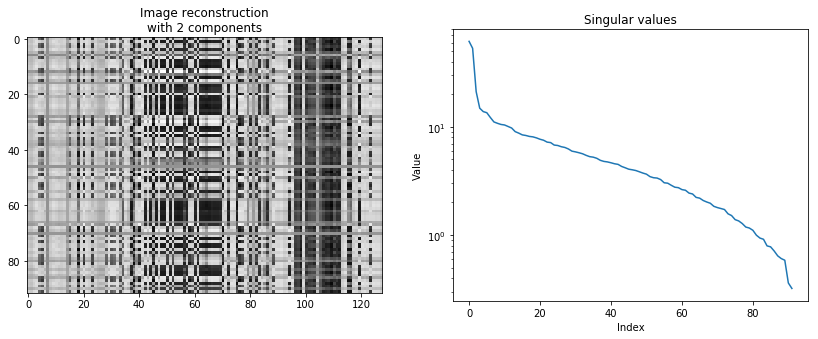

In [37]:
# Center the data at zero
X = A - np.mean(A)

print(len(X))

# Singular-value decomposition
U, s, VT = scipy.linalg.svd(X)

# create m x n Sigma matrix
Sigma = np.zeros((A.shape[0], A.shape[1]))

# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[0], :A.shape[0]] = np.diag(s)

# select
n_elements = 2
Sigma = Sigma[:, :n_elements]
VT = VT[:n_elements, :]

# reconstruct
T99 = U.dot(Sigma)
B99 = T99.dot(VT)

fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].imshow(B99,cmap="gray");
ax[0].set_title("Image reconstruction\nwith %d components" % n_elements)
ax[1].semilogy(s);
ax[1].set_title("Singular values")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Value")

In [26]:
len(U)

92

Text(0, 0.5, 'Second component')

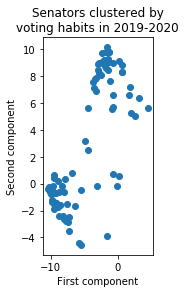

In [12]:
# Here's a plot of the data. It shows the senators clustering into two
# main clusters. One of the clusters is more varied than the other, suggesting
# more independence within that cluster. It also shows there are a number of 
# senators who do not really vote with either cluster.

T = U.dot(Sigma)
plt.scatter(T[:,0], T[:,1])
plt.gca().set_aspect(2)
plt.title("Senators clustered by\nvoting habits in 2019-2020")
plt.xlabel("First component")
plt.ylabel("Second component")

In [19]:
len(my_data)

67811

__Senator party Information__

In [17]:
my_data[:10]

array([[  -1,   -1,   -1,   -1,   -1,   -1],
       [ 106,   -1,    1,   86,    1,   -1],
       [ 106,   -1,    1,  -52,    1,   -1],
       [ 106,   -1,    1, -103,    1,   -1],
       [ 106,   -1,    1,   56,    1,   -1],
       [ 106,   -1,    1,   36,    1,   -1],
       [ 106,   -1,    1,  -60,    1,   -1],
       [ 106,   -1,    1,   77,    1,   -1],
       [ 106,   -1,    1,  -17,    1,   -1],
       [ 106,   -1,    1,    0,    1,   -1]], dtype=int8)